In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import torchvision.transforms.functional as TF
import random
import torch.nn as nn
import math

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda
from tqdm import tqdm

from dataset import GTA

In [3]:
# path = "data/GTAV/small/00001.png"
# img = cv2.imread(path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# plt.show()
# img.size * img.itemsize

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
scaling_factor = 2
crop_size = 96*scaling_factor
# large_kernel_size = 9
# small_kernel_size = 3
# n_channels = 64
# n_blocks = 16
lr_img_type = '[0, 1]' #'gta-small-norm'
hr_img_type = '[0, 1]'

batch_size = 32
epochs = 2
lr = 1e-4
#grad_clip = None

train_path = 'data/GTAV/small/'
training_data = GTA(train_path,'train',crop_size, scaling_factor,lr_img_type,hr_img_type, same_size_input=True)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_data = GTA(train_path,'test',crop_size, scaling_factor,lr_img_type,hr_img_type, same_size_input=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

In [6]:
# batch = next(iter(test_dataloader))
# print(len(batch))
# plt.imshow(batch[0][0].permute(1, 2, 0))
# plt.show()
# plt.imshow(batch[1][0].permute(1, 2, 0))
# plt.show()
# print(batch[0][0].shape, batch[1][0].shape)

In [7]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        return x

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv_block = ConvBlock(in_channels, out_channels)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv_block(x)
        p = self.max_pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.concat_conv = ConvBlock(in_channels + skip_channels, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)  # Concatenate along the channel dimension
        x = self.concat_conv(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_classes, img_channels, initial_depth = 16, height=5):
        super(UNet, self).__init__()
        self.height = height

        # List of encoders
        self.encoders = nn.ModuleList()

        current_channels = initial_depth
        previous_channels = img_channels
        for _ in range(height):
            self.encoders.append(EncoderBlock(previous_channels, current_channels))
            previous_channels = current_channels
            current_channels *= 2

        # Bottleneck
        self.bottleneck = ConvBlock(previous_channels, current_channels)

        # List of decoders
        self.decoders = nn.ModuleList()
        for _ in range(height):
            previous_channels = current_channels
            current_channels //= 2
            self.decoders.append(DecoderBlock(previous_channels, current_channels, current_channels))

        # Final convolution layer
        self.final_conv = nn.Conv2d(initial_depth, n_classes, kernel_size=1)
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder path
        c = []
        for i in range(self.height):
            c_i, x = self.encoders[i](x)
            c.append(c_i)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path
        for i in range(self.height):
            x = self.decoders[i](x, c[-(i + 1)])

        # Final output
        output = self.final_conv(x)
        # output = self.sigmoid(output)
        return output



### Tuning

In [8]:
torch.cuda.empty_cache()
model = UNet(n_classes=3, img_channels=3).to(device)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [9]:
def train(epochs = 3):
    criterion = nn.MSELoss().to(device)

    for epoch in range(epochs):
        print("EPOCH",epoch+1)
        running_loss = 0
        print_freq = 20
        loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}")
        for i,(lr_imgs, hr_imgs) in enumerate(loop):
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)

            sr_imgs = model(lr_imgs)

            loss = criterion(sr_imgs, hr_imgs)

            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            running_loss += loss.item()
            if i % print_freq==print_freq-1:
                current_loss = running_loss / print_freq
                running_loss = 0

                loop.set_postfix(loss=current_loss) 

In [10]:
def calculate_psnr(sr, hr, max_pixel_value=1.0):
    """
    Calculate PSNR between SR (super-resolved) and HR (high-resolution) images.
    Args:
        sr (numpy array): Super-resolved image.
        hr (numpy array): High-resolution ground-truth image.
        max_pixel_value (float): Maximum possible pixel value (1.0 for normalized images).
    Returns:
        psnr (float): Peak Signal-to-Noise Ratio.
    """
    mse = np.mean((sr - hr) ** 2)
    if mse == 0:
        return float('inf')  # Perfect match
    psnr = 20 * math.log10(max_pixel_value / math.sqrt(mse))
    return psnr




In [11]:
def evaluate():
    # Loop to calculate PSNR for the first 100 images
    psnr_list = []
    with torch.no_grad():
        for idx, (lr_img, hr_img) in enumerate(training_data):
            if idx >= 100:  # Limit to the first 100 images
                break

            # Evaluate the model
            model.eval()
            sr_img = model(lr_img.unsqueeze(0).to(device)).to('cpu').squeeze(0).permute(1, 2, 0).numpy()

            sr_img = np.clip(sr_img, 0, 1)  # Clamp SR values to valid range [0, 1]
            hr_img = hr_img.permute(1, 2, 0).numpy()  # Convert HR tensor to numpy array
            
            # Calculate PSNR
            psnr = calculate_psnr(sr_img, hr_img, max_pixel_value=1.0)
            psnr_list.append(psnr)

    # Calculate average PSNR over 100 images
    average_psnr = np.mean(psnr_list)    
    return average_psnr * (-1) # higher PSNR is better so I multiply it by -1

In [12]:
best_result = float('inf')
best_architecture = None
for architecture in [(8,3),(16,5), (24,6)]:
    model = UNet(n_classes=3, img_channels=3, initial_depth=architecture[0], height=architecture[1]).to(device)

    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    train()
    result = evaluate()
    if result < best_result:
        best_result = result
        best_architecture = architecture
print(f'Best architecture is {best_architecture}')

best_result = float('inf')
best_loss = None
for loss in ['mse', 'mae', 'crossEntropy']:
    model = UNet(n_classes=3, img_channels=3, initial_depth=best_architecture[0], height=best_architecture[1]).to(device)

    if loss== 'mse': loss_fn = torch.nn.MSELoss()
    elif loss== 'mae': loss_fn = torch.nn.L1Loss()
    elif loss== 'crossEntropy': loss_fn = torch.nn.CrossEntropyLoss()
    else: raise RuntimeError("unable to handle error")

    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    train()
    result = evaluate()
    if result < best_result:
        best_result = result
        best_loss = loss
print(f'Best loss function is {best_loss}')

best_result = float('inf')
best_optimizer = None
for optimizer_name in ['adam', 'SGD', 'RMSprop']:
    model = UNet(n_classes=3, img_channels=3, initial_depth=best_architecture[0], height=best_architecture[1]).to(device)

    if best_loss== 'mse': loss_fn = torch.nn.MSELoss()
    elif best_loss== 'mae': loss_fn = torch.nn.L1Loss()
    elif best_loss== 'crossEntropy': loss_fn = torch.nn.CrossEntropyLoss()
    else: raise RuntimeError("unable to handle error")

    if optimizer_name == 'adam':optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    elif optimizer_name == 'SGD':optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
    elif optimizer_name == 'RMSprop':optimizer = torch.optim.RMSprop(model.parameters(), lr=0.005)
    else: raise RuntimeError("unable to handle error")

    train()
    result = evaluate()
    if result < best_result:
        best_result = result
        best_optimizer = optimizer_name
print(f'Best optimizer is {best_optimizer}')

best_result = float('inf')
best_lr = None
for lr in [0.0025, 0.005, 0.01]:
    model = UNet(n_classes=3, img_channels=3, initial_depth=best_architecture[0], height=best_architecture[1]).to(device)

    if best_loss== 'mse': loss_fn = torch.nn.MSELoss()
    elif best_loss== 'mae': loss_fn = torch.nn.L1Loss()
    elif best_loss== 'crossEntropy': loss_fn = torch.nn.CrossEntropyLoss()
    else: raise RuntimeError("unable to handle error")

    if best_optimizer == 'adam':optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    elif best_optimizer == 'SGD':optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    elif best_optimizer == 'RMSprop':optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    else: raise RuntimeError("unable to handle error")

    train()
    result = evaluate()
    if result < best_result:
        best_result = result
        best_lr = lr
print(f'Best learning rate is {best_lr}')

EPOCH 1


Epoch 1/3:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/3:  99%|█████████▊| 78/79 [00:57<00:00,  1.67it/s, loss=0.0669]/home/deniz/.local/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/3: 100%|██████████| 79/79 [00:57<00:00,  1.38it/s, loss=0.0669]


EPOCH 2


Epoch 2/3: 100%|██████████| 79/79 [00:55<00:00,  1.43it/s, loss=0.0136]


EPOCH 3


Epoch 3/3: 100%|██████████| 79/79 [00:54<00:00,  1.45it/s, loss=0.00536]


EPOCH 1


Epoch 1/3:  99%|█████████▊| 78/79 [01:08<00:00,  1.37it/s, loss=0.225]   /home/deniz/.local/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/3: 100%|██████████| 79/79 [01:08<00:00,  1.15it/s, loss=0.225]


EPOCH 2


Epoch 2/3: 100%|██████████| 79/79 [01:03<00:00,  1.25it/s, loss=0.025] 


EPOCH 3


Epoch 3/3: 100%|██████████| 79/79 [01:01<00:00,  1.28it/s, loss=0.0138]


EPOCH 1


Epoch 1/3: 100%|██████████| 79/79 [01:23<00:00,  1.06s/it, loss=0.205]  


EPOCH 2


Epoch 2/3: 100%|██████████| 79/79 [01:24<00:00,  1.07s/it, loss=0.198]


EPOCH 3


Epoch 3/3: 100%|██████████| 79/79 [01:25<00:00,  1.08s/it, loss=0.195]


Best architecture is (8, 3)
EPOCH 1


Epoch 1/3: 100%|██████████| 79/79 [00:47<00:00,  1.68it/s, loss=0.00794]


EPOCH 2


Epoch 2/3: 100%|██████████| 79/79 [00:54<00:00,  1.45it/s, loss=0.0048] 


EPOCH 3


Epoch 3/3: 100%|██████████| 79/79 [00:49<00:00,  1.59it/s, loss=0.00449]


EPOCH 1


Epoch 1/3: 100%|██████████| 79/79 [00:46<00:00,  1.71it/s, loss=0.0235]


EPOCH 2


Epoch 2/3: 100%|██████████| 79/79 [00:47<00:00,  1.67it/s, loss=0.00669]


EPOCH 3


Epoch 3/3: 100%|██████████| 79/79 [00:46<00:00,  1.69it/s, loss=0.00549]


EPOCH 1


Epoch 1/3: 100%|██████████| 79/79 [00:48<00:00,  1.63it/s, loss=0.0358]


EPOCH 2


Epoch 2/3: 100%|██████████| 79/79 [00:53<00:00,  1.48it/s, loss=0.00473]


EPOCH 3


Epoch 3/3: 100%|██████████| 79/79 [00:51<00:00,  1.54it/s, loss=0.00288]


Best loss function is crossEntropy
EPOCH 1


Epoch 1/3: 100%|██████████| 79/79 [00:59<00:00,  1.33it/s, loss=0.0825]


EPOCH 2


Epoch 2/3: 100%|██████████| 79/79 [01:01<00:00,  1.28it/s, loss=0.0355]


EPOCH 3


Epoch 3/3: 100%|██████████| 79/79 [01:04<00:00,  1.22it/s, loss=0.0118]


EPOCH 1


Epoch 1/3: 100%|██████████| 79/79 [01:01<00:00,  1.29it/s, loss=0.349]


EPOCH 2


Epoch 2/3: 100%|██████████| 79/79 [01:11<00:00,  1.10it/s, loss=0.215]


EPOCH 3


Epoch 3/3: 100%|██████████| 79/79 [01:05<00:00,  1.21it/s, loss=0.136]


EPOCH 1


Epoch 1/3: 100%|██████████| 79/79 [01:08<00:00,  1.15it/s, loss=0.512]  


EPOCH 2


Epoch 2/3: 100%|██████████| 79/79 [01:11<00:00,  1.11it/s, loss=0.455]


EPOCH 3


Epoch 3/3: 100%|██████████| 79/79 [01:08<00:00,  1.15it/s, loss=0.432]


Best optimizer is adam
EPOCH 1


Epoch 1/3: 100%|██████████| 79/79 [01:11<00:00,  1.10it/s, loss=0.362]


EPOCH 2


Epoch 2/3: 100%|██████████| 79/79 [01:13<00:00,  1.07it/s, loss=0.0136]


EPOCH 3


Epoch 3/3: 100%|██████████| 79/79 [01:07<00:00,  1.17it/s, loss=0.00373]


EPOCH 1


Epoch 1/3: 100%|██████████| 79/79 [01:22<00:00,  1.04s/it, loss=0.0228]


EPOCH 2


Epoch 2/3: 100%|██████████| 79/79 [01:23<00:00,  1.05s/it, loss=0.00432]


EPOCH 3


Epoch 3/3: 100%|██████████| 79/79 [01:27<00:00,  1.10s/it, loss=0.00328]


EPOCH 1


Epoch 1/3: 100%|██████████| 79/79 [01:21<00:00,  1.03s/it, loss=0.0983]


EPOCH 2


Epoch 2/3: 100%|██████████| 79/79 [01:13<00:00,  1.07it/s, loss=0.0649]


EPOCH 3


Epoch 3/3: 100%|██████████| 79/79 [01:15<00:00,  1.04it/s, loss=0.0643]


Best learning rate is 0.0025


### Stuff after tuning

In [13]:
torch.cuda.empty_cache()
model = UNet(n_classes=3, img_channels=3, initial_depth=best_architecture[0], height=best_architecture[1]).to(device)

if best_loss== 'mse': loss_fn = torch.nn.MSELoss()
elif best_loss== 'mae': loss_fn = torch.nn.L1Loss()
elif best_loss== 'crossEntropy': loss_fn = torch.nn.CrossEntropyLoss()
else: raise RuntimeError("unable to handle error")

if best_optimizer == 'adam':optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
elif best_optimizer == 'SGD':optimizer = torch.optim.SGD(model.parameters(), lr=best_lr)
elif best_optimizer == 'RMSprop':optimizer = torch.optim.RMSprop(model.parameters(), lr=best_lr)
else: raise RuntimeError("unable to handle error")

In [14]:
losses = []

In [15]:
criterion = nn.MSELoss().to(device)
start_epoch = 0

epochs = 10
for epoch in range(epochs):
    print("EPOCH",epoch+start_epoch+1)
    running_loss = 0
    print_freq = 20
    loop = tqdm(train_dataloader, desc=f"Epoch {epoch+1+start_epoch}/{epochs+start_epoch}")
    for i,(lr_imgs, hr_imgs) in enumerate(loop):
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        sr_imgs = model(lr_imgs)

        loss = criterion(sr_imgs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()

        # # Clip gradients, if necessary
        # if grad_clip is not None:
        #     clip_gradient(optimizer, grad_clip)

        optimizer.step()
        running_loss += loss.item()
        if i % print_freq==print_freq-1:
            current_loss = running_loss / print_freq
            losses.append(current_loss)
            running_loss = 0

            loop.set_postfix(loss=current_loss)


EPOCH 1


Epoch 1/10: 100%|██████████| 79/79 [01:27<00:00,  1.11s/it, loss=0.0117]


EPOCH 2


Epoch 2/10: 100%|██████████| 79/79 [01:19<00:00,  1.01s/it, loss=0.00416]


EPOCH 3


Epoch 3/10: 100%|██████████| 79/79 [01:31<00:00,  1.16s/it, loss=0.0021] 


EPOCH 4


Epoch 4/10: 100%|██████████| 79/79 [01:34<00:00,  1.20s/it, loss=0.00143]


EPOCH 5


Epoch 5/10: 100%|██████████| 79/79 [01:28<00:00,  1.12s/it, loss=0.00123]


EPOCH 6


Epoch 6/10: 100%|██████████| 79/79 [01:33<00:00,  1.19s/it, loss=0.00113]


EPOCH 7


Epoch 7/10: 100%|██████████| 79/79 [01:26<00:00,  1.09s/it, loss=0.00114]


EPOCH 8


Epoch 8/10: 100%|██████████| 79/79 [01:30<00:00,  1.15s/it, loss=0.00111]


EPOCH 9


Epoch 9/10: 100%|██████████| 79/79 [01:32<00:00,  1.16s/it, loss=0.00102] 


EPOCH 10


Epoch 10/10: 100%|██████████| 79/79 [01:24<00:00,  1.07s/it, loss=0.00112]


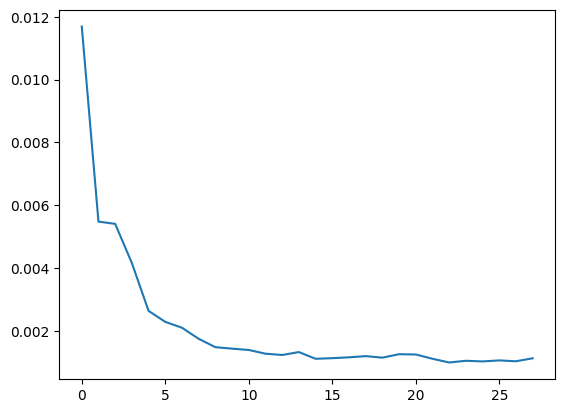

In [20]:
plt.plot(losses[2:])
plt.show()

In [17]:
len(losses)

30

torch.Size([3, 192, 192]) torch.Size([3, 192, 192])
0.098039225


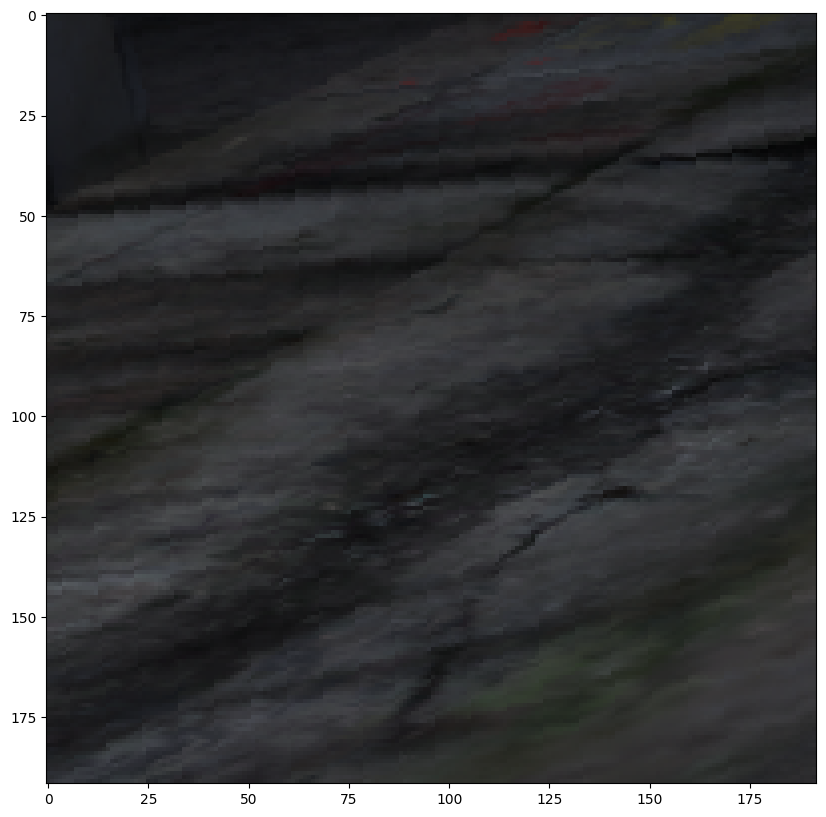

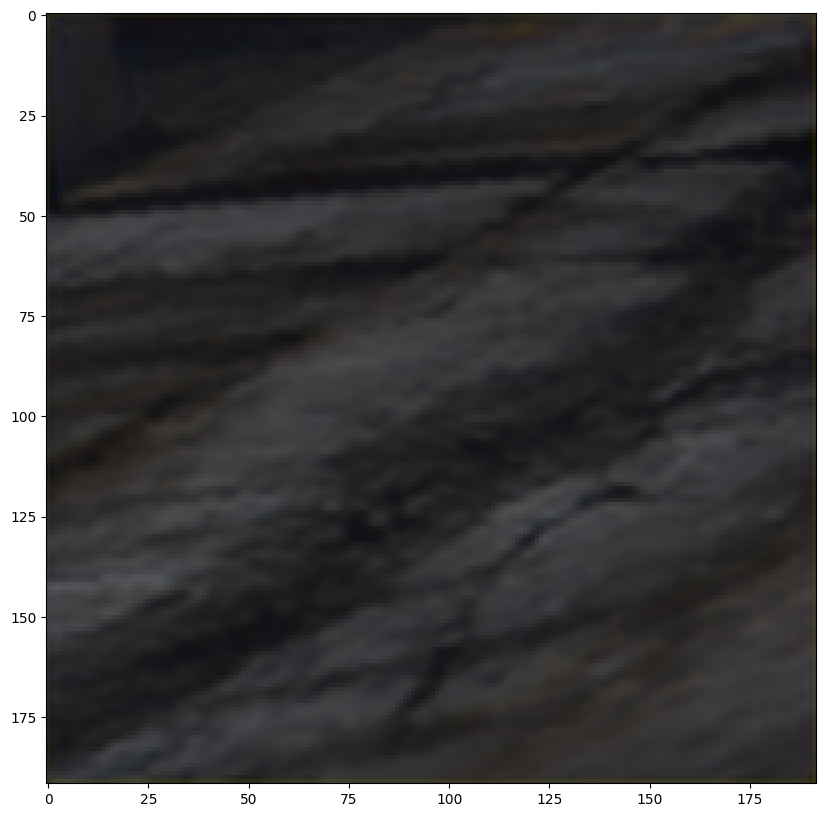

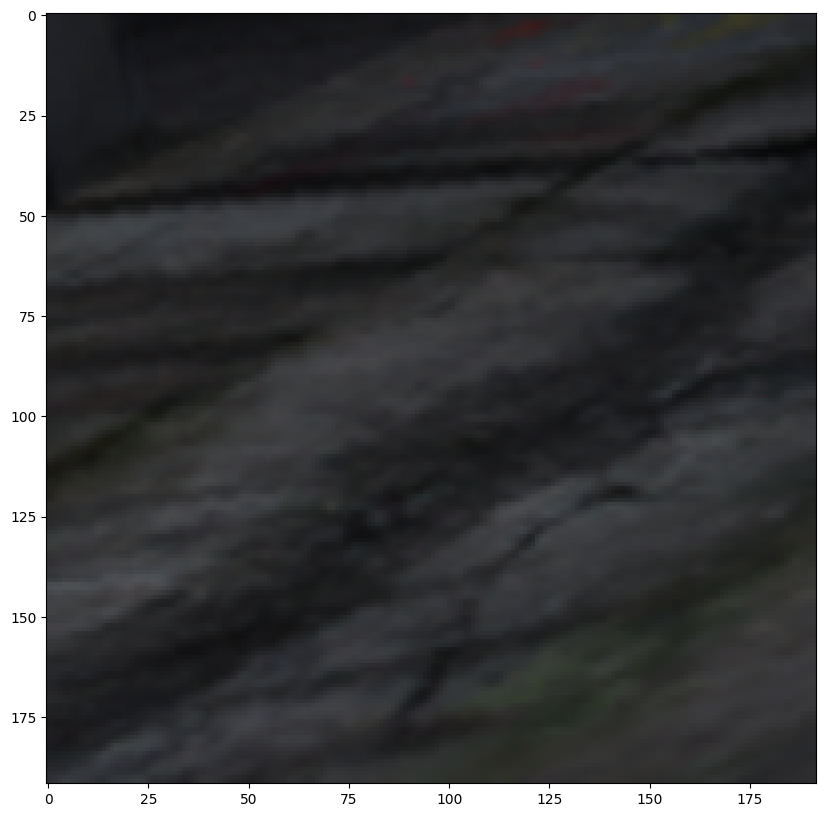

In [18]:
with torch.no_grad():
    for lr_img, hr_img in training_data:
        print(lr_img.shape, hr_img.shape)
        print(np.max(abs(lr_img.numpy() - hr_img.numpy())))

        model.eval()
        sr_img = model(lr_img.unsqueeze(0).to(device)).to('cpu').squeeze(0).permute(1, 2, 0).numpy()
        # plt.imshow(np.concatenate([sr_img, (hr_img).permute(1, 2, 0).numpy()], axis=1))
        # plt.show()
        size = (10,10)
        plt.figure(figsize=size)
        plt.imshow((hr_img).permute(1, 2, 0).numpy())
        plt.show()
        plt.figure(figsize=size)
        plt.imshow(sr_img)
        plt.show()
        plt.figure(figsize=size)
        plt.imshow((lr_img).permute(1, 2, 0).numpy())
        plt.show()
        break

In [19]:
torch.save({'epoch': len(losses),
                    'model': model,
                    'optimizer': optimizer},
                   'checkpoint_Unet_optimized.pth.tar')